In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, minmax_scale

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from itertools import cycle
from sklearn.mixture import GaussianMixture

In [2]:
info_estudiantes=pd.read_csv('./datos/informacion_por_estudiante_de_IP.csv')
envios=pd.read_csv('./datos/todos_los_envios.csv')
problemas= pd.read_csv('./datos/todos_problemas.csv')
estudiantes_seccion = pd.read_csv('./datos/todos_estudiantes_seccion.csv')
tareas = pd.read_csv('./datos/todo_tareas.csv')
problemas_tareas= pd.read_csv('./datos/todo_problemas_tareas.csv')
resultado_estudiante= pd.read_csv('./datos/todo_resultado_estudiante.csv')

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3135: DtypeWarning: Columns (134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3135: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Objetivo:
# Como se calculan los puntos a detalle y ver si los puntos tienen una mayor incidencia sobre la nota
#Ver la incidencia de los puntos sobre las notas prácticas


In [4]:
estudiantes_seccion = estudiantes_seccion[['usuario_ptr_id','seccion_id']]

In [5]:
info_estudiantes_det= info_estudiantes[['id','n1_global','n2_global','n3_global','n4_global','retiro','semestre','puntos']]
info_estudiantes_det= info_estudiantes_det[(info_estudiantes_det['n1_global']>=0) & (info_estudiantes_det['n1_global']<6) &
                                           (info_estudiantes_det['n2_global']>=0)  & (info_estudiantes_det['n2_global']<6) &
                                           (info_estudiantes_det['n3_global']>=0) & (info_estudiantes_det['n3_global']<6) &
                                           (info_estudiantes_det['n4_global']>=0) & (info_estudiantes_det['n4_global']<6) ]
info_estudiantes_det= info_estudiantes_det[(info_estudiantes_det['n1_global']>0) |  (info_estudiantes_det['n2_global']>0) |
                                           (info_estudiantes_det['n3_global']>0) | (info_estudiantes_det['n4_global']>0)]
info_estudiantes_det = info_estudiantes_det.rename(columns={"id": "estudiante_id"})
info_estudiantes_det.fillna(value="NR", inplace=True)

info_estudiantes_det['estudiante_id'] = info_estudiantes_det['estudiante_id'].astype(str)
info_estudiantes_det['semestre'] = info_estudiantes_det['semestre'].astype(str)

info_estudiantes_det['est_sem_id'] =  info_estudiantes_det['estudiante_id'] + info_estudiantes_det['semestre'] 

info_estudiantes_det


,estudiante_id,n1_global,n2_global,n3_global,n4_global,retiro,semestre,puntos,est_sem_id
4,867,2.19,2.89,3.350000,3.97,NR,202010,166,867202010
5,910,4.57,4.92,4.460000,3.71,NR,202010,138,910202010
7,1186,3.67,4.08,4.320000,3.44,NR,202010,91,1186202010
8,1394,4.58,4.31,4.190000,4.37,NR,202010,146,1394202010
9,1436,4.94,4.70,3.680000,2.65,NR,202010,125,1436202010
...,...,...,...,...,...,...,...,...,...
7918,5286,4.30,4.52,5.000000,0.00,NR,202210,239,5286202210
7921,5709,4.70,3.48,4.800000,0.00,NR,202210,148,5709202210
7922,5865,4.60,2.92,3.942857,0.00,NR,202210,85,5865202210
7924,5996,4.70,4.72,4.314286,0.00,NR,202210,275,5996202210


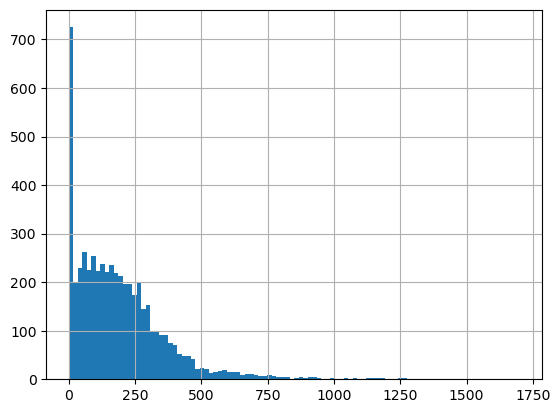

In [6]:
hist = (info_estudiantes_det['puntos'])[info_estudiantes_det['retiro']=="NR"].hist(bins=100)

In [7]:
# Los puntos se obtienen respecto a menos envíos se realizan sobre un problema menos puntos del total obtiene
#puntos = dificultad

In [8]:
problemas = problemas.rename(columns={"id": "problema_id"})

In [9]:
resultado_estudiante_problemas= pd.merge(resultado_estudiante,problemas,on='problema_id')
resultado_estudiante_problemas

,id,resuelto,primer_intento,puntos,estudiante_id,problema_id,ultimo_intento,ultimo_envio_id,titulo,curso_id,autor_id,dificultad,estado,funcion,retorno_tipo,publico,nivel,ultima_modificacion,nivel_reto
0,65,1,2019-09-09 16:47:13.606744,10,524,117.0,NaN,136261.0,Área de una habitación,1,362,10,NU,area_habitacion,float,1,1,2019-09-09 16:00:21.955652,B
1,66,1,2019-09-09 17:20:15.104411,10,526,117.0,NaN,70785.0,Área de una habitación,1,362,10,NU,area_habitacion,float,1,1,2019-09-09 16:00:21.955652,B
2,125,1,2019-09-10 02:53:29.240175,10,529,117.0,NaN,213.0,Área de una habitación,1,362,10,NU,area_habitacion,float,1,1,2019-09-09 16:00:21.955652,B
3,454,1,2019-09-11 13:13:25.196147,10,523,117.0,NaN,136910.0,Área de una habitación,1,362,10,NU,area_habitacion,float,1,1,2019-09-09 16:00:21.955652,B
4,455,0,2019-09-11 13:14:57.738138,0,398,117.0,NaN,247.0,Área de una habitación,1,362,10,NU,area_habitacion,float,1,1,2019-09-09 16:00:21.955652,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135489,133747,0,2022-05-25 19:11:07.847961,0,5737,265.0,NaN,NaN,Anomalías en fechas de vacunación,1,466,20,NU,mostrar_anomalias,pd.Series,1,4,2021-08-31 12:41:33.247998,M
135490,133749,0,2022-05-25 19:11:07.873423,0,5744,265.0,NaN,NaN,Anomalías en fechas de vacunación,1,466,20,NU,mostrar_anomalias,pd.Series,1,4,2021-08-31 12:41:33.247998,M
135491,133751,0,2022-05-25 19:11:07.899830,0,5740,265.0,NaN,NaN,Anomalías en fechas de vacunación,1,466,20,NU,mostrar_anomalias,pd.Series,1,4,2021-08-31 12:41:33.247998,M
135492,133753,0,2022-05-25 19:11:07.925366,0,5728,265.0,NaN,NaN,Anomalías en fechas de vacunación,1,466,20,NU,mostrar_anomalias,pd.Series,1,4,2021-08-31 12:41:33.247998,M


In [41]:
resultado_estudiante_problemas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135494 entries, 0 to 135493
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   135494 non-null  int64  
 1   resuelto             135494 non-null  int64  
 2   primer_intento       135494 non-null  object 
 3   puntos               135494 non-null  int64  
 4   estudiante_id        135494 non-null  int64  
 5   problema_id          135494 non-null  float64
 6   ultimo_intento       2 non-null       object 
 7   ultimo_envio_id      100412 non-null  float64
 8   titulo               135494 non-null  object 
 9   curso_id             135494 non-null  int64  
 10  autor_id             135494 non-null  int64  
 11  dificultad           135494 non-null  int64  
 12  estado               135494 non-null  object 
 13  funcion              135494 non-null  object 
 14  retorno_tipo         135494 non-null  object 
 15  publico          

In [10]:
def conseguir_anio(texto):
    return (texto.split()[0]).split("-")[0]
def conseguir_mes(texto):
    return (texto.split()[0]).split("-")[1]
def conseguir_dia(texto):
    return (texto.split()[0]).split("-")[2]

In [11]:
resultado_estudiante_problemas['Anio'] = (resultado_estudiante_problemas['primer_intento'].apply(conseguir_anio))
resultado_estudiante_problemas['Mes'] = (resultado_estudiante_problemas['primer_intento'].apply(conseguir_mes))
resultado_estudiante_problemas['Dia'] = (resultado_estudiante_problemas['primer_intento'].apply(conseguir_dia))
resultado_estudiante_problemas['Anio'] = resultado_estudiante_problemas['Anio'].astype(int)
resultado_estudiante_problemas['Mes'] = resultado_estudiante_problemas['Mes'].astype(int)
resultado_estudiante_problemas['Dia'] = resultado_estudiante_problemas['Dia'].astype(int)

In [12]:
resultado_estudiante_problemas['semestre'] = np.where((resultado_estudiante_problemas['Anio']==2022) & (resultado_estudiante_problemas['Mes']<6) & (resultado_estudiante_problemas['Mes']>=1),"202210",
                     np.where((resultado_estudiante_problemas['Anio']==2021) & (resultado_estudiante_problemas['Mes']<=12) & (resultado_estudiante_problemas['Mes']>=8),"202120",
                     np.where((resultado_estudiante_problemas['Anio']==2021) & (resultado_estudiante_problemas['Mes']<6) & (resultado_estudiante_problemas['Mes']>=1),"202110",
                     np.where((resultado_estudiante_problemas['Anio']==2020) & (resultado_estudiante_problemas['Mes']<=12) & (resultado_estudiante_problemas['Mes']>=8),"202020",
                     np.where((resultado_estudiante_problemas['Anio']==2020) & (resultado_estudiante_problemas['Mes']<6) & (resultado_estudiante_problemas['Mes']>=1),"202010",
                     np.where((resultado_estudiante_problemas['Anio']==2019) & (resultado_estudiante_problemas['Mes']<=12) & (resultado_estudiante_problemas['Mes']>=8),"201920",
                     np.where((resultado_estudiante_problemas['Anio']==2019)  & (resultado_estudiante_problemas['Mes']<6) & (resultado_estudiante_problemas['Mes']>=1),"201910",
                              
                     np.where((resultado_estudiante_problemas['Anio']==2021)  & (resultado_estudiante_problemas['Mes']<8) & (resultado_estudiante_problemas['Mes']>=6),"202119",
                     np.where((resultado_estudiante_problemas['Anio']==2020)  & (resultado_estudiante_problemas['Mes']<8) & (resultado_estudiante_problemas['Mes']>=6),"202019",
                     np.where((resultado_estudiante_problemas['Anio']==2022)  & (resultado_estudiante_problemas['Mes']<=8) & (resultado_estudiante_problemas['Mes']>=6),"202219","No match date"))))))))))

In [13]:
resultado_estudiante_problemas_mod= resultado_estudiante_problemas.copy()

In [14]:
resultado_estudiante_problemas_mod['estudiante_id'] = resultado_estudiante_problemas_mod['estudiante_id'].astype(str)
resultado_estudiante_problemas_mod['semestre'] = resultado_estudiante_problemas_mod['semestre'].astype(str)

resultado_estudiante_problemas_mod['est_sem_id'] =  resultado_estudiante_problemas_mod['estudiante_id'] + resultado_estudiante_problemas_mod['semestre'] 

In [15]:
resultado_estudiante_problemas_mod.describe()

,id,resuelto,puntos,problema_id,ultimo_envio_id,curso_id,autor_id,dificultad,publico,nivel,Anio,Mes,Dia
count,135494.000000,135494.000000,135494.000000,135494.000000,100412.000000,135494.0,135494.000000,135494.000000,135494.000000,135494.000000,135494.000000,135494.000000,135494.000000
mean,67852.462618,0.660133,8.171801,172.709581,149207.084034,1.0,507.922557,17.055515,0.964596,2.375603,2020.728667,5.720903,15.964884
std,39144.991244,0.473666,9.326043,38.474084,86800.177461,0.0,390.134357,9.097213,0.184799,1.032913,0.779739,3.294150,8.791369
min,65.000000,0.000000,0.000000,116.000000,181.000000,1.0,362.000000,5.000000,0.000000,1.000000,2019.000000,1.000000,1.000000
25%,33941.250000,0.000000,0.000000,142.000000,74714.500000,1.0,362.000000,10.000000,1.000000,1.000000,2020.000000,3.000000,8.000000
50%,67886.500000,1.000000,7.000000,163.000000,148235.500000,1.0,520.000000,15.000000,1.000000,2.000000,2021.000000,5.000000,17.000000
75%,101759.750000,1.000000,12.000000,198.000000,225333.750000,1.0,522.000000,20.000000,1.000000,3.000000,2021.000000,9.000000,23.000000
max,135633.000000,1.000000,51.000000,272.000000,300599.000000,1.0,4141.000000,45.000000,1.000000,4.000000,2022.000000,12.000000,31.000000


In [16]:
puntos_por_nivel_estudiante=(resultado_estudiante_problemas_mod[['est_sem_id','nivel','puntos']].groupby(['est_sem_id','nivel']).sum())
puntos_por_nivel_estudiante = puntos_por_nivel_estudiante['puntos'].reset_index()
puntos_por_nivel_estudiante

,est_sem_id,nivel,puntos
0,1000202010,1,18
1,1000202010,2,4
2,1000202010,3,0
3,1001202010,1,44
4,1001202010,2,135
...,...,...,...
22700,999202010,1,459
22701,999202010,2,271
22702,999202010,3,334
22703,999202010,4,40


In [17]:
info_estudiantes_det

,estudiante_id,n1_global,n2_global,n3_global,n4_global,retiro,semestre,puntos,est_sem_id
4,867,2.19,2.89,3.350000,3.97,NR,202010,166,867202010
5,910,4.57,4.92,4.460000,3.71,NR,202010,138,910202010
7,1186,3.67,4.08,4.320000,3.44,NR,202010,91,1186202010
8,1394,4.58,4.31,4.190000,4.37,NR,202010,146,1394202010
9,1436,4.94,4.70,3.680000,2.65,NR,202010,125,1436202010
...,...,...,...,...,...,...,...,...,...
7918,5286,4.30,4.52,5.000000,0.00,NR,202210,239,5286202210
7921,5709,4.70,3.48,4.800000,0.00,NR,202210,148,5709202210
7922,5865,4.60,2.92,3.942857,0.00,NR,202210,85,5865202210
7924,5996,4.70,4.72,4.314286,0.00,NR,202210,275,5996202210


In [18]:
df_final = pd.merge(info_estudiantes_det[['est_sem_id','estudiante_id','n1_global','n2_global','n3_global','n4_global','retiro','semestre']],puntos_por_nivel_estudiante,on='est_sem_id')

In [19]:
df_final.describe()

,n1_global,n2_global,n3_global,n4_global,nivel,puntos
count,16802.000000,16802.000000,16802.000000,16802.000000,16802.000000,16802.000000
mean,4.017918,3.375478,3.035481,2.150648,2.492977,54.357636
std,1.065623,1.392184,1.713556,1.970179,1.105895,61.770180
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.800000,2.664000,1.890000,0.000000,2.000000,10.000000
50%,4.380000,3.770000,3.657143,2.430000,2.000000,38.000000
75%,4.740000,4.440000,4.420000,4.090000,3.000000,78.000000
max,5.120000,5.050000,5.180000,5.490000,4.000000,666.000000


In [20]:
df_final

,est_sem_id,estudiante_id,n1_global,n2_global,n3_global,n4_global,retiro,semestre,nivel,puntos
0,867202010,867,2.19,2.89,3.350000,3.97,NR,202010,1,10
1,867202010,867,2.19,2.89,3.350000,3.97,NR,202010,2,37
2,867202010,867,2.19,2.89,3.350000,3.97,NR,202010,3,92
3,867202010,867,2.19,2.89,3.350000,3.97,NR,202010,4,27
4,910202010,910,4.57,4.92,4.460000,3.71,NR,202010,1,40
...,...,...,...,...,...,...,...,...,...,...
16797,5996202210,5996,4.70,4.72,4.314286,0.00,NR,202210,4,40
16798,6097202210,6097,1.00,0.84,0.000000,0.00,NR,202210,1,30
16799,6097202210,6097,1.00,0.84,0.000000,0.00,NR,202210,2,0
16800,6097202210,6097,1.00,0.84,0.000000,0.00,NR,202210,3,0


<AxesSubplot:>

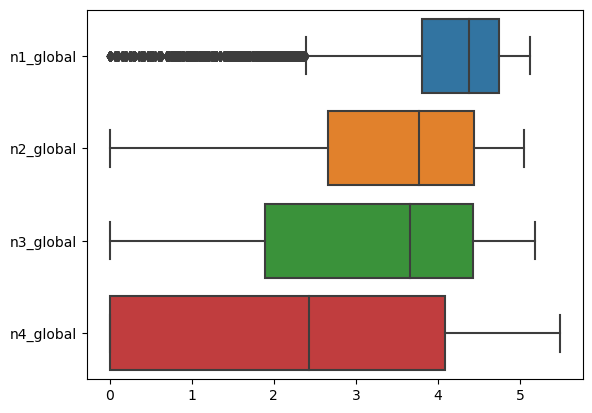

In [21]:
sns.boxplot(data=df_final[['n1_global','n2_global','n3_global','n4_global']], orient="h")

<AxesSubplot:>

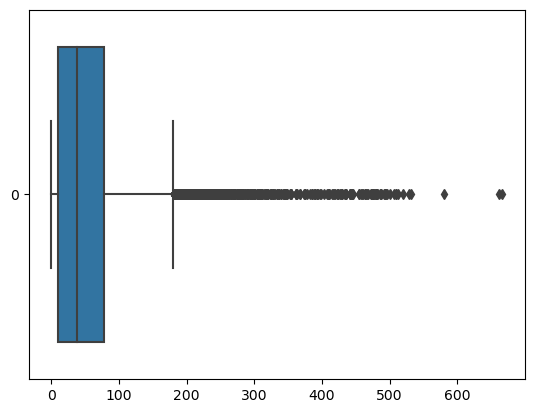

In [22]:
sns.boxplot(data=df_final['puntos'], orient="h")

In [23]:
# Seleccionamos los no Outliers usando percentiles
per = 95

# Depuración de las anomalías en las columnas.
num_envios = (df_final['puntos'] < np.percentile(df_final['puntos'] , per))


In [24]:
df_final= df_final[num_envios].copy()

In [25]:
per_b = 5
n1_global_no_out= (df_final['n1_global'] > np.percentile(df_final['n1_global'] , per_b))

In [26]:
df_final= df_final[n1_global_no_out].copy()

<AxesSubplot:>

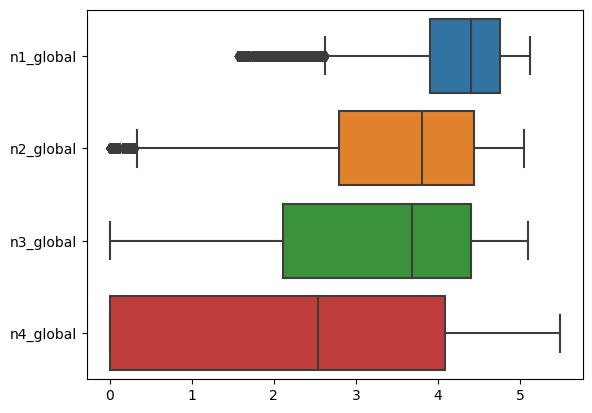

In [27]:
sns.boxplot(data=df_final[['n1_global','n2_global','n3_global','n4_global']], orient="h")

<AxesSubplot:>

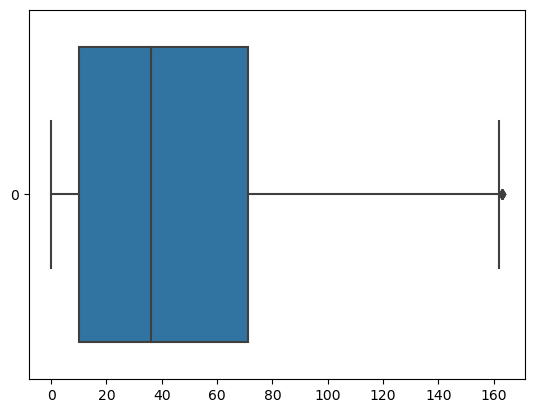

In [28]:
sns.boxplot(data=df_final['puntos'], orient="h")

In [29]:
df_final['retiroOno'] = np.where((df_final['retiro']=='NR'),1,0)

In [30]:
columnas=['puntos','n1_global','n2_global','n3_global','n4_global','retiroOno']
df_nivel1= (df_final[(df_final['nivel']==1) ])
df_nivel2=df_final[(df_final['nivel']==2) ]
df_nivel3= df_final[(df_final['nivel']==3) ]
df_nivel4=df_final[(df_final['nivel']==4) ]
corr_df1= df_nivel1[['puntos','n1_global']].corr(method='pearson')
corr_df2= df_nivel2[['puntos','n2_global']].corr(method='pearson')
corr_df3= df_nivel3[['puntos','n3_global']].corr(method='pearson')
corr_df4= df_nivel4[['puntos','n4_global']].corr(method='pearson')

In [42]:
df_nivel1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3593 entries, 0 to 16794
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     3593 non-null   object 
 1   estudiante_id  3593 non-null   object 
 2   n1_global      3593 non-null   float64
 3   n2_global      3593 non-null   float64
 4   n3_global      3593 non-null   float64
 5   n4_global      3593 non-null   float64
 6   retiro         3593 non-null   object 
 7   semestre       3593 non-null   object 
 8   nivel          3593 non-null   int64  
 9   puntos         3593 non-null   int64  
 10  retiroOno      3593 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 322.8+ KB


In [43]:
df_nivel2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3811 entries, 1 to 16795
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     3811 non-null   object 
 1   estudiante_id  3811 non-null   object 
 2   n1_global      3811 non-null   float64
 3   n2_global      3811 non-null   float64
 4   n3_global      3811 non-null   float64
 5   n4_global      3811 non-null   float64
 6   retiro         3811 non-null   object 
 7   semestre       3811 non-null   object 
 8   nivel          3811 non-null   int64  
 9   puntos         3811 non-null   int64  
 10  retiroOno      3811 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 342.4+ KB


In [44]:
df_nivel3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3916 entries, 2 to 16796
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     3916 non-null   object 
 1   estudiante_id  3916 non-null   object 
 2   n1_global      3916 non-null   float64
 3   n2_global      3916 non-null   float64
 4   n3_global      3916 non-null   float64
 5   n4_global      3916 non-null   float64
 6   retiro         3916 non-null   object 
 7   semestre       3916 non-null   object 
 8   nivel          3916 non-null   int64  
 9   puntos         3916 non-null   int64  
 10  retiroOno      3916 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 351.8+ KB


In [45]:
df_nivel4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3839 entries, 3 to 16797
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     3839 non-null   object 
 1   estudiante_id  3839 non-null   object 
 2   n1_global      3839 non-null   float64
 3   n2_global      3839 non-null   float64
 4   n3_global      3839 non-null   float64
 5   n4_global      3839 non-null   float64
 6   retiro         3839 non-null   object 
 7   semestre       3839 non-null   object 
 8   nivel          3839 non-null   int64  
 9   puntos         3839 non-null   int64  
 10  retiroOno      3839 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 344.9+ KB


<AxesSubplot:>

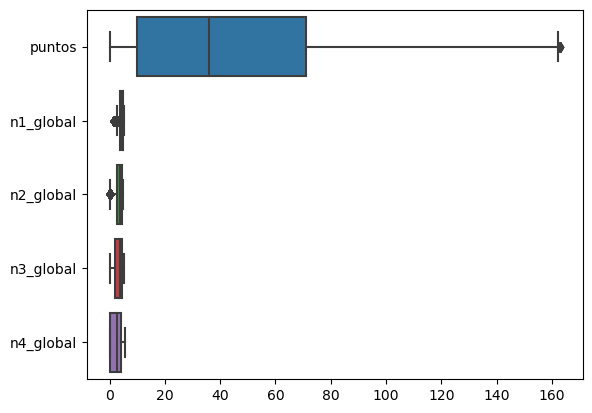

In [31]:
sns.boxplot(data=df_final[['puntos','n1_global','n2_global','n3_global','n4_global']], orient="h")

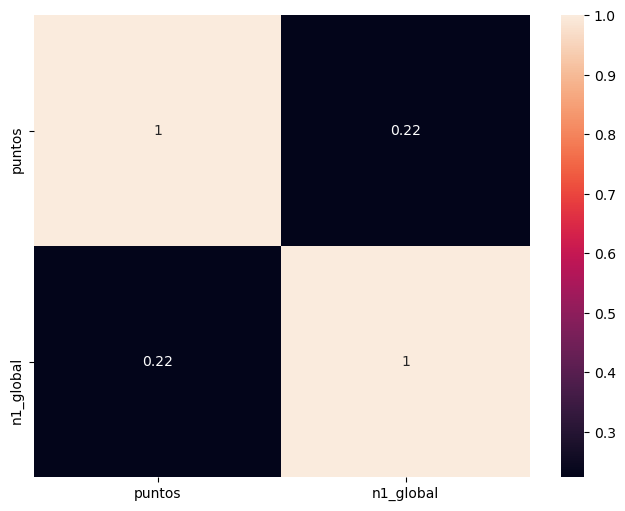

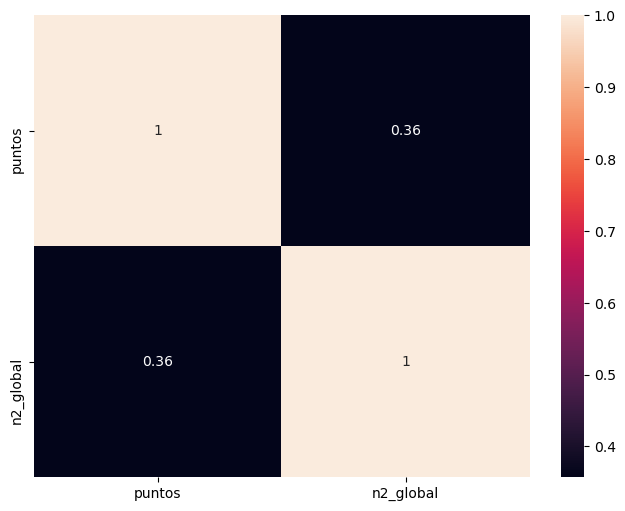

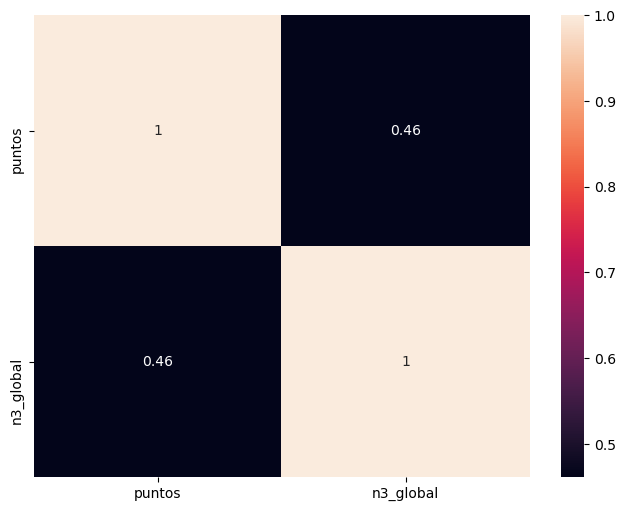

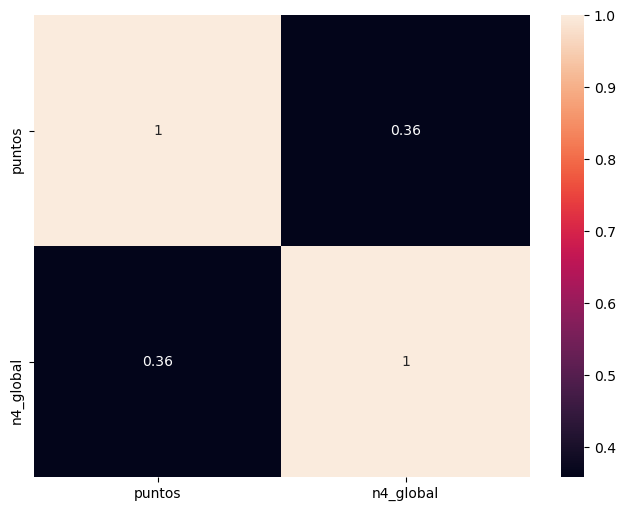

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df1[['puntos','n1_global']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df2[['puntos','n2_global']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df3[['puntos','n3_global']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df4[['puntos','n4_global']], annot=True)
plt.show()

## Notas por ejercicios y/o practico

In [46]:
info_estudiantes_practico= info_estudiantes[['id','n1_practico','n2_practico','n3_practico','n4_practico','retiro','semestre']]
info_estudiantes_practico= info_estudiantes_practico[(info_estudiantes_practico['n1_practico']>=0) & (info_estudiantes_practico['n1_practico']<6) & (info_estudiantes_practico['n2_practico']>=0)  & (info_estudiantes_practico['n2_practico']<6) & (info_estudiantes_practico['n3_practico']>=0) & (info_estudiantes_practico['n3_practico']<6) & (info_estudiantes_practico['n4_practico']>=0) & (info_estudiantes_practico['n4_practico']<6) ]
info_estudiantes_practico= info_estudiantes_practico[(info_estudiantes_practico['n1_practico']>0) |  (info_estudiantes_practico['n2_practico']>0) | (info_estudiantes_practico['n3_practico']>0) | (info_estudiantes_practico['n4_practico']>0)]
info_estudiantes_practico = info_estudiantes_practico.rename(columns={"id": "estudiante_id"})
info_estudiantes_practico.fillna(value="NR", inplace=True)

info_estudiantes_practico['estudiante_id'] = info_estudiantes_practico['estudiante_id'].astype(str)
info_estudiantes_practico['semestre'] = info_estudiantes_practico['semestre'].astype(str)

info_estudiantes_practico['est_sem_id'] =  info_estudiantes_practico['estudiante_id'] + info_estudiantes_practico['semestre'] 

info_estudiantes_practico


,estudiante_id,n1_practico,n2_practico,n3_practico,n4_practico,retiro,semestre,est_sem_id
4,867,2.85,2.70,2.50,3.85,NR,202010,867202010
5,910,5.00,4.75,5.00,5.00,NR,202010,910202010
7,1186,4.52,3.35,4.65,3.00,NR,202010,1186202010
8,1394,4.85,3.45,3.72,4.75,NR,202010,1394202010
9,1436,5.25,4.85,4.80,3.10,NR,202010,1436202010
...,...,...,...,...,...,...,...,...
7918,5286,3.50,4.35,5.00,0.00,NR,202210,5286202210
7921,5709,5.00,3.15,5.00,0.00,NR,202210,5709202210
7922,5865,4.25,2.65,3.67,0.00,NR,202210,5865202210
7924,5996,4.50,4.60,4.20,0.00,NR,202210,5996202210


In [47]:
info_estudiantes_practico.describe()

,n1_practico,n2_practico,n3_practico,n4_practico
count,6617.000000,6617.000000,6617.000000,6617.000000
mean,3.869309,3.126083,2.610880,1.778785
std,1.123153,1.518094,1.836817,1.947103
min,0.000000,0.000000,0.000000,0.000000
25%,3.300000,2.250000,0.100000,0.000000
50%,4.200000,3.450000,3.050000,0.680000
75%,4.750000,4.380000,4.250000,3.730000
max,5.500000,5.750000,5.500000,5.750000


In [48]:
df_final = pd.merge(info_estudiantes_practico[['est_sem_id','estudiante_id','n1_practico','n2_practico','n3_practico','n4_practico','retiro','semestre']],puntos_por_nivel_estudiante,on='est_sem_id')

In [49]:
df_final.describe()

,n1_practico,n2_practico,n3_practico,n4_practico,nivel,puntos
count,16463.000000,16463.000000,16463.000000,16463.000000,16463.000000,16463.000000
mean,3.964698,3.353575,3.091401,2.229885,2.491344,54.900140
std,1.075756,1.426154,1.711766,2.002999,1.105605,61.532182
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.500000,2.580000,2.070000,0.000000,2.000000,11.000000
50%,4.250000,3.700000,3.600000,2.550000,2.000000,38.000000
75%,4.750000,4.500000,4.500000,4.150000,3.000000,79.000000
max,5.500000,5.750000,5.500000,5.750000,4.000000,666.000000


<AxesSubplot:>

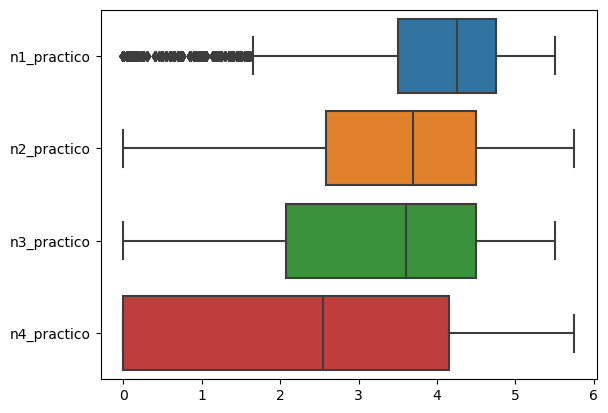

In [50]:
sns.boxplot(data=df_final[['n1_practico','n2_practico','n3_practico','n4_practico']], orient="h")

<AxesSubplot:>

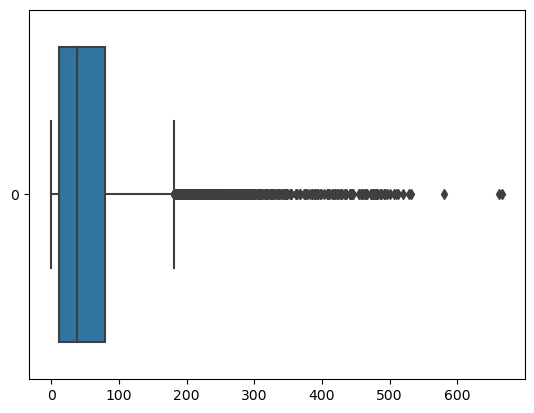

In [51]:
sns.boxplot(data=df_final['puntos'], orient="h")

In [52]:
# Seleccionamos los no Outliers usando percentiles
per = 95

# Depuración de las anomalías en las columnas.
num_envios = (df_final['puntos'] < np.percentile(df_final['puntos'] , per))


In [53]:
df_final= df_final[num_envios].copy()

In [54]:
per_b = 5
n1_global_no_out= (df_final['n1_practico'] > np.percentile(df_final['n1_practico'] , per_b))

In [55]:
df_final= df_final[n1_global_no_out].copy()

<AxesSubplot:>

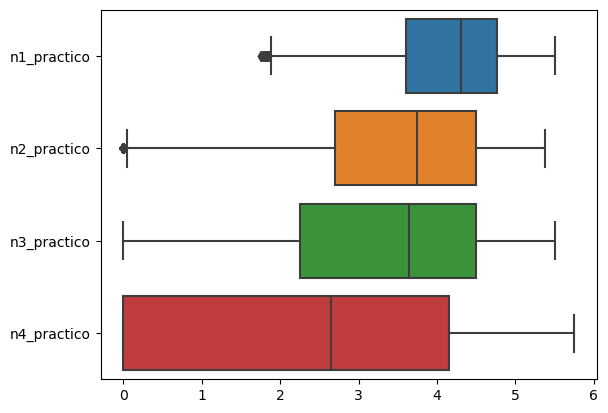

In [56]:
sns.boxplot(data=df_final[['n1_practico','n2_practico','n3_practico','n4_practico']], orient="h")

<AxesSubplot:>

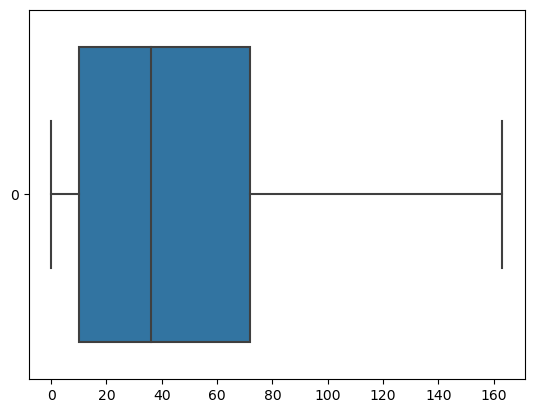

In [57]:
sns.boxplot(data=df_final['puntos'], orient="h")

In [58]:
df_final['retiroOno'] = np.where((df_final['retiro']=='NR'),1,0)

In [59]:
columnas=['puntos','n1_practico','n2_practico','n3_practico','n4_practico','retiroOno']
df_nivel1= (df_final[(df_final['nivel']==1) ])
df_nivel2=df_final[(df_final['nivel']==2) ]
df_nivel3= df_final[(df_final['nivel']==3) ]
df_nivel4=df_final[(df_final['nivel']==4) ]
corr_df1= df_nivel1[['puntos','n1_practico']].corr(method='pearson')
corr_df2= df_nivel2[['puntos','n2_practico']].corr(method='pearson')
corr_df3= df_nivel3[['puntos','n3_practico']].corr(method='pearson')
corr_df4= df_nivel4[['puntos','n4_practico']].corr(method='pearson')

<AxesSubplot:>

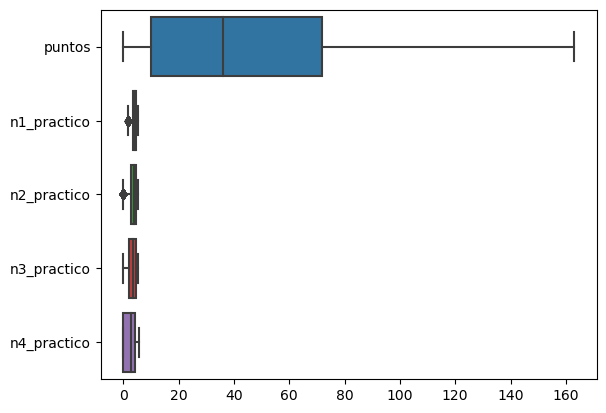

In [60]:
sns.boxplot(data=df_final[['puntos','n1_practico','n2_practico','n3_practico','n4_practico']], orient="h")

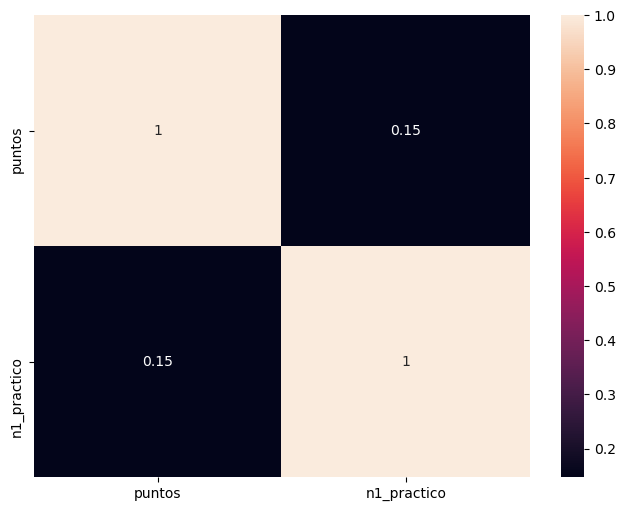

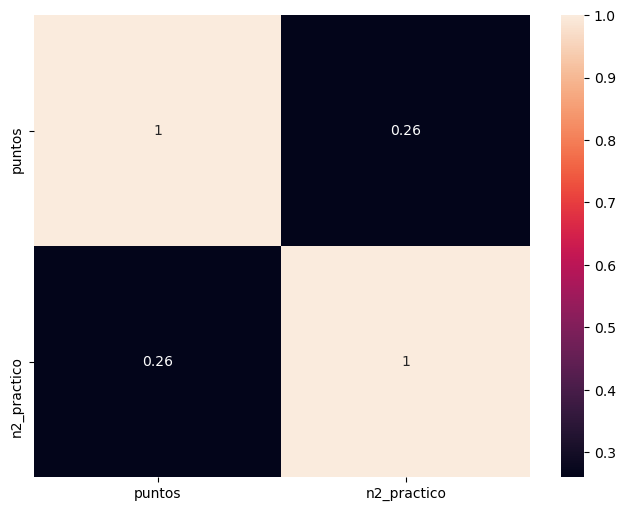

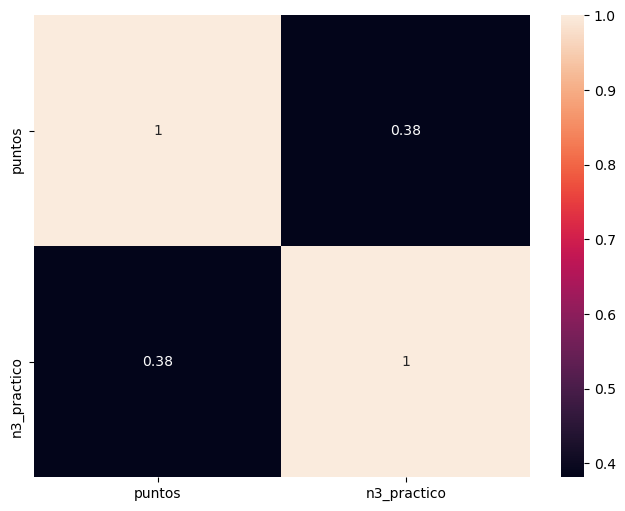

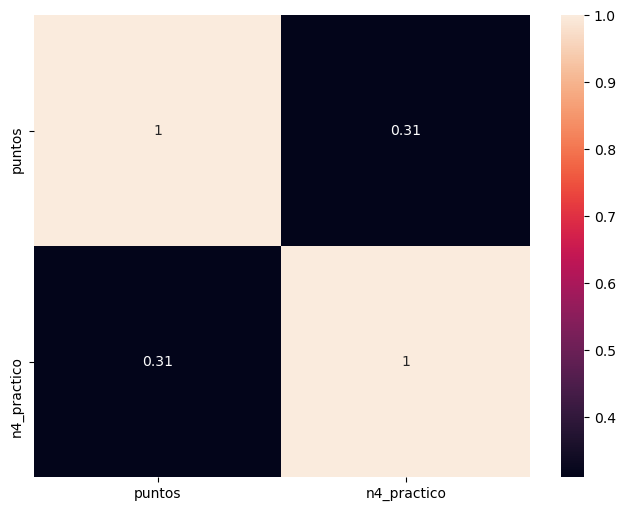

In [61]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df1[['puntos','n1_practico']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df2[['puntos','n2_practico']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df3[['puntos','n3_practico']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df4[['puntos','n4_practico']], annot=True)
plt.show()